In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [2]:
from PIL import Image
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<h1> Конвертация изображений в чб</h1>

In [20]:
def TurnImgBW(directory, savedir, flag):
    i = 0
    for file in os.listdir(directory):
        i += 1 + flag
        filename = os.fsdecode(file)
        image_file = Image.open(os.path.join(directory, filename)) # open colour image
        image_file = image_file.convert('L') # convert image to black and white
        newfilename = str(i) + '.png'
        image_file.save(os.path.join(savedir, newfilename))


In [21]:
TurnImgBW('data\\lips\\resized\\Before\\', 'data\\lips\\resized\\classified\\class0\\', 0)
TurnImgBW('data\\lips\\resized\\After\\', 'data\\lips\\resized\\classified\\class1\\', 1000)

<h1> Формирование обучающего и валидационного датасетов</h1>

In [22]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = 'data\\lips\\resized\\classified'

In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 80% на обучение, 20% на тест
    subset="training",
    seed=123,  # Для воспроизводимости
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

#def normalize_img(image, label):
#    image = tf.cast(image, tf.float32) / 255.0
#    return image, label
#
#train_ds = train_ds.map(normalize_img)
#val_ds = val_ds.map(normalize_img)

Found 472 files belonging to 2 classes.
Using 378 files for training.
Found 472 files belonging to 2 classes.
Using 94 files for validation.


In [24]:
# Проверка данных
for images, labels in train_ds.take(1):
    print("Размер батча изображений:", images.shape)
    print("Метки:", labels.numpy())

# Проверка данных
for images, labels in val_ds.take(1):
    print("Размер батча изображений:", images.shape)
    print("Метки:", labels.numpy())

Размер батча изображений: (32, 224, 224, 3)
Метки: [0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0]
Размер батча изображений: (32, 224, 224, 3)
Метки: [0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0]


<h1> Аугментация данных: чтобы разбавить датасеты отразим каждую картинку по горизонтали, повернем изображения направо и налево на 30 градусов</h1>

In [25]:
# Слой для аугментации
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Отражение по горизонтали
    tf.keras.layers.RandomRotation(factor=0.083),  # Поворот на ±30 градусов (30°/360° ≈ 0.083)
])

# Пример применения аугментации
def prepare_data_with_augmentation(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x), y))
# Проверка данных
for images, labels in train_ds.take(1):
    print("Размер батча изображений до аугментации:", images.shape)
    print("Метки:", labels.numpy())
# Применяем аугментацию к обучающему датасету
train_ds = prepare_data_with_augmentation(train_ds)

# Проверка данных
for images, labels in train_ds.take(1):
    print("Размер батча изображений после аугментации:", images.shape)
    print("Метки:", labels.numpy())

Размер батча изображений до аугментации: (32, 224, 224, 3)
Метки: [0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1]
Размер батча изображений после аугментации: (32, 224, 224, 3)
Метки: [0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0]


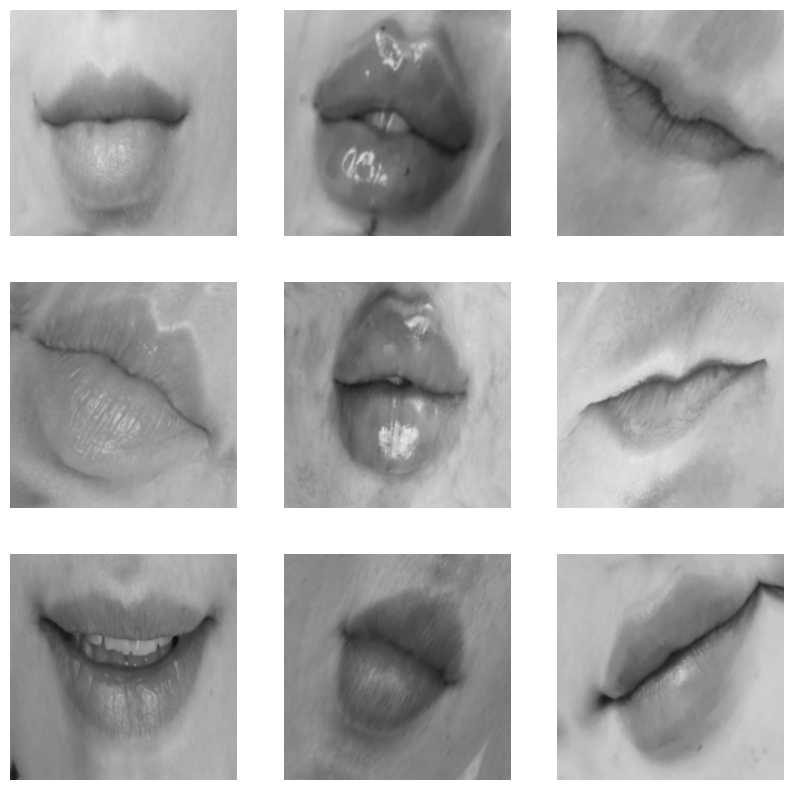

In [26]:
def show_augmented_images(dataset, augmentation_layer, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):  # Берем один батч
        augmented_images = augmentation_layer(images)  # Применяем аугментацию
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

# Выводим аугментированные изображения
show_augmented_images(train_ds, data_augmentation)

<h1> Попробуем сделать простую CNN</h1>

In [10]:
input_shape = (224, 224, 3)
num_classes = 2

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #layers.Dense(512, activation='relu'),
        layers.Dense(2, activation="softmax"),
    ]
)

# 2 classes
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Если метки 0 и 1
              metrics=['accuracy'])

# 1 class
#model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)     

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
epochs = 10  # Число эпох обучения, можно подстроить под задачу

history = model.fit(
    train_ds,  # Обучающий датасет
    validation_data=val_ds,  # Валидационный датасет
    epochs=epochs
)

Epoch 1/10
24/24 [==============================] - 5s 74ms/step - loss: 84.3157 - accuracy: 0.4974 - val_loss: 0.6835 - val_accuracy: 0.5851
Epoch 2/10
24/24 [==============================] - 1s 45ms/step - loss: 0.6974 - accuracy: 0.5291 - val_loss: 0.6748 - val_accuracy: 0.5319
Epoch 3/10
24/24 [==============================] - 1s 45ms/step - loss: 0.7166 - accuracy: 0.5688 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
24/24 [==============================] - 1s 45ms/step - loss: 0.6801 - accuracy: 0.5794 - val_loss: 0.6894 - val_accuracy: 0.5638
Epoch 5/10
24/24 [==============================] - 1s 45ms/step - loss: 0.6929 - accuracy: 0.5370 - val_loss: 0.6918 - val_accuracy: 0.4894
Epoch 6/10
24/24 [==============================] - 1s 44ms/step - loss: 0.7379 - accuracy: 0.5608 - val_loss: 0.6899 - val_accuracy: 0.4787
Epoch 7/10
24/24 [==============================] - 1s 45ms/step - loss: 0.6917 - accuracy: 0.4974 - val_loss: 0.6863 - val_accuracy: 0.5000
Epoch 8/10
2

<h1>Попробуем сделать optuna</h1>

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

class CNNTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, epochs=50, learning_rate=0.001, filters1=32, filters2=64, filters3=128, dense_units=512, dropout_rate=0.5, verbose=0):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.filters1 = filters1
        self.filters2 = filters2
        self.filters3 = filters3
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.verbose = verbose
        self.model = None

    def fit(self, dataset):
        input_shape = (224, 224, 3)  # Входная форма данных, например (224, 224, 3)

        # Определение архитектуры CNN
        model = models.Sequential([
            layers.Conv2D(self.filters1, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(self.filters2, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(self.filters3, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(self.dense_units, activation='relu'),
            layers.Dropout(self.dropout_rate),
            layers.Dense(1, activation='sigmoid')  # Для бинарной классификации
        ])

        # Компиляция модели
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Обучение модели с датасетом
        model.fit(dataset, epochs=self.epochs, verbose=self.verbose)
        self.model = model
        return self

    def transform(self, X):
        # CNNTrainer не изменяет данные, поэтому просто возвращаем X
        return X

    def predict(self, dataset):
        # Предсказать классы для новых данных X
        if self.model is None:
            raise ValueError("Модель не обучена")
        
        y_pred = []
        for images, _ in dataset:
            y_pred_prob = self.model.predict(images)
            y_pred.extend((y_pred_prob > 0.5).astype(int).flatten())  # Преобразуем вероятности в классы 0 или 1
        return y_pred

    def score(self, dataset):
        # Проверка на то, что модель уже обучена
        if self.model is None:
            raise ValueError("Модель не обучена")

        # Извлечение истинных и предсказанных меток
        y_true = []
        y_pred = []
        
        for images, labels in dataset:
            # Получение предсказаний для текущей партии изображений
            predictions = self.model.predict(images)
            predicted_labels = (predictions > 0.5).astype(int)
            
            y_true.extend(labels.numpy())
            y_pred.extend(predicted_labels.flatten())

        # Вычисление точности
        return accuracy_score(y_true, y_pred)


In [10]:
import optuna

In [17]:
import optuna
from sklearn.pipeline import Pipeline

# Определяем функцию objective для Optuna
def objective(trial):
    # Параметры для оптимизации
    param = {
        'epochs': trial.suggest_categorical('epochs', [10, 20, 30]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'filters1': trial.suggest_categorical('filters1', [16, 32, 64, 128]),
        'filters2': trial.suggest_categorical('filters2', [32, 64, 128, 256]),
        'filters3': trial.suggest_categorical('filters3', [64, 128, 256, 512]),
        'dense_units': trial.suggest_categorical('dense_units', [128, 256, 512, 1024]),
        'dropout_rate': trial.suggest_categorical('dropout_rate', [0, 0.1, 0.2, 0.3, 0.4, 0.5]),
        'verbose': trial.suggest_categorical('verbose', [0])
    }

    # Создаем экземпляр CNNTrainer с заданными параметрами
    cnn_model = CNNTrainer(**param)

    # Обучаем модель на тренировочном датасете
    cnn_model.fit(train_ds)

    # Получаем оценку точности на тренировочном наборе
    val_accuracy = cnn_model.score(train_ds)

    return val_accuracy  # Оптимизируем точность на тренировочных данных



In [18]:
study = optuna.create_study(direction='maximize')  # 'maximize' for accuracy, 'minimize' for loss
study.optimize(objective, n_trials=15)

[I 2024-10-30 07:03:25,585] A new study created in memory with name: no-name-730c9a60-1e51-44aa-add0-fff3b502c8a8
C:\Users\vboro\AppData\Local\Temp\ipykernel_20492\339092600.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 0s 16ms/step


[I 2024-10-30 07:03:56,322] Trial 0 finished with value: 0.5079365079365079 and parameters: {'epochs': 20, 'learning_rate': 0.0022018473569934537, 'filters1': 64, 'filters2': 32, 'filters3': 256, 'dense_units': 128, 'dropout_rate': 0.3, 'verbose': 0}. Best is trial 0 with value: 0.5079365079365079.
C:\Users\vboro\AppData\Local\Temp\ipykernel_20492\339092600.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 0s 15ms/step


[I 2024-10-30 07:04:20,630] Trial 1 finished with value: 0.582010582010582 and parameters: {'epochs': 10, 'learning_rate': 1.7922031265027384e-05, 'filters1': 64, 'filters2': 64, 'filters3': 512, 'dense_units': 256, 'dropout_rate': 0.3, 'verbose': 0}. Best is trial 1 with value: 0.582010582010582.
C:\Users\vboro\AppData\Local\Temp\ipykernel_20492\339092600.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 0s 15ms/step


[I 2024-10-30 07:05:18,318] Trial 2 finished with value: 0.7037037037037037 and parameters: {'epochs': 20, 'learning_rate': 2.690253930993385e-05, 'filters1': 32, 'filters2': 256, 'filters3': 512, 'dense_units': 256, 'dropout_rate': 0.2, 'verbose': 0}. Best is trial 2 with value: 0.7037037037037037.
C:\Users\vboro\AppData\Local\Temp\ipykernel_20492\339092600.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 0s 14ms/step


[I 2024-10-30 07:05:43,146] Trial 3 finished with value: 0.5211640211640212 and parameters: {'epochs': 10, 'learning_rate': 0.0009519980342415362, 'filters1': 32, 'filters2': 128, 'filters3': 256, 'dense_units': 1024, 'dropout_rate': 0.2, 'verbose': 0}. Best is trial 2 with value: 0.7037037037037037.
C:\Users\vboro\AppData\Local\Temp\ipykernel_20492\339092600.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 0s 16ms/step


[I 2024-10-30 07:06:40,626] Trial 4 finished with value: 0.5423280423280423 and parameters: {'epochs': 30, 'learning_rate': 0.00021448595872702457, 'filters1': 32, 'filters2': 256, 'filters3': 64, 'dense_units': 256, 'dropout_rate': 0.5, 'verbose': 0}. Best is trial 2 with value: 0.7037037037037037.
C:\Users\vboro\AppData\Local\Temp\ipykernel_20492\339092600.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[W 2024-10-30 07:06:51,685] Trial 5 failed with parameters: {'epochs': 10, 'learning_rate': 0.00013483658169290258, 'filters1': 64, 'filters2': 32, 'filters3': 128, 'dense_units': 256, 'dropout_rate': 0.5, 'verbose': 0} because of the following error: ResourceExhaustedError().
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\envs\py3

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_17/max_pooling2d_48/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\vboro\AppData\Local\Temp\ipykernel_20492\304635675.py", line 2, in <module>
      study.optimize(objective, n_trials=15)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\optuna\study\study.py", line 475, in optimize
      _optimize(
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\optuna\study\_optimize.py", line 63, in _optimize
      _optimize_sequential(
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\optuna\study\_optimize.py", line 160, in _optimize_sequential
      frozen_trial = _run_trial(study, func, catch)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
      value_or_values = func(trial)
    File "C:\Users\vboro\AppData\Local\Temp\ipykernel_20492\339092600.py", line 22, in objective
      cnn_model.fit(train_ds)
    File "C:\Users\vboro\AppData\Local\Temp\ipykernel_20492\3347773567.py", line 41, in fit
      model.fit(dataset, epochs=self.epochs, verbose=self.verbose)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\ProgramData\anaconda3\envs\py310gpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_17/max_pooling2d_48/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[16,222,222,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_17/max_pooling2d_48/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_77363]

In [ ]:
# Trial 2 finished with value: 0.7936507936507936 and parameters: {'epochs': 20, 'learning_rate': 2.765343018031512e-05, 'filters1': 128, 'filters2': 64, 'filters3': 256, 'dense_units': 256, 'dropout_rate': 0.3, 'verbose': 0}. Best is trial 2 with value: 0.7936507936507936.

In [ ]:
# Trial 1 finished with value: 0.8544973544973545 and parameters: {'epochs': 20, 'learning_rate': 0.00010832689582432518, 'filters1': 32, 'filters2': 64, 'filters3': 128, 'dense_units': 512, 'dropout_rate': 0.2, 'verbose': 0}.

<h1> Обычная CNN модель достигла максимальной accuracy = 0.8. Попробуем модель EfficientNet, в ней заморозим верхние слои, чтобы использовать предобученные признаки.</h1>

In [24]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.applications import EfficientNetB0

class EfficientNetTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, epochs=50, learning_rate=0.001, dense_units=512, dropout_rate=0.5, verbose=0):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.verbose = verbose
        self.model = None

    def build_model(self, input_shape=(224, 224, 3)):
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
        base_model.trainable = False  # Замораживаем базовую модель

        # Создаем модель
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(self.dense_units, activation='relu'),
            layers.Dropout(self.dropout_rate),
            layers.Dense(1, activation='sigmoid')  # Бинарная классификация
        ])

        # Компиляция модели
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, dataset):
        # Строим и обучаем модель
        self.model = self.build_model()
        self.model.fit(dataset, epochs=self.epochs, verbose=self.verbose)
        return self

    def transform(self, X):
        # EfficientNetTrainer не изменяет данные, поэтому просто возвращаем X
        return X

    def predict(self, dataset):
        if self.model is None:
            raise ValueError("Модель не обучена")
        
        y_pred = []
        for images, _ in dataset:
            y_pred_prob = self.model.predict(images)
            y_pred.extend((y_pred_prob > 0.5).astype(int).flatten())
        return y_pred

    def score(self, dataset):
        if self.model is None:
            raise ValueError("Модель не обучена")

        y_true = []
        y_pred = []
        
        for images, labels in dataset:
            predictions = self.model.predict(images)
            predicted_labels = (predictions > 0.5).astype(int)
            
            y_true.extend(labels.numpy())
            y_pred.extend(predicted_labels.flatten())

        return accuracy_score(y_true, y_pred)

    def evaluate_and_plot_confusion_matrix(self, dataset):
        if self.model is None:
            raise ValueError("Модель не обучена")

        y_true = []
        y_pred = []

        for images, labels in dataset:
            predictions = self.model.predict(images)
            predicted_labels = (predictions > 0.5).astype(int)
            
            y_true.extend(labels.numpy())
            y_pred.extend(predicted_labels.flatten())
        
        # Построение матрицы ошибок
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()
        
        # Возвращаем точность для удобства
        return accuracy_score(y_true, y_pred)

In [14]:
def objective(trial):
    param = {
        'epochs': trial.suggest_categorical('epochs', [10, 20, 30, 40, 50]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'dense_units': trial.suggest_categorical('dense_units', [128, 256, 512, 1024]),
        'dropout_rate': trial.suggest_categorical('dropout_rate', [0, 0.1, 0.2, 0.3, 0.4, 0.5]),
        'verbose': trial.suggest_categorical('verbose', [0])
    }

    # Создаем экземпляр EfficientNetTrainer с заданными параметрами
    efficient_net_model = EfficientNetTrainer(**param)

    # Обучаем модель
    efficient_net_model.fit(train_ds)

    # Получаем оценку точности на тренировочном наборе
    val_accuracy = efficient_net_model.score(train_ds)

    return val_accuracy

In [15]:
study = optuna.create_study(direction='maximize')  # 'maximize' for accuracy, 'minimize' for loss
study.optimize(objective, n_trials=15)

[I 2024-10-30 19:44:21,196] A new study created in memory with name: no-name-770a5556-b419-4882-983b-23cf8dcefd85
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 866ms/step


[I 2024-10-30 19:45:37,765] Trial 0 finished with value: 0.9497354497354498 and parameters: {'epochs': 40, 'learning_rate': 0.016723833490971774, 'dense_units': 512, 'dropout_rate': 0.5, 'verbose': 0}. Best is trial 0 with value: 0.9497354497354498.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-10-30 19:46:33,037] Trial 1 finished with value: 0.8835978835978836 and parameters: {'epochs': 40, 'learning_rate': 5.935002924407161e-05, 'dense_units': 128, 'dropout_rate': 0, 'verbose': 0}. Best is trial 0 with value: 0.9497354497354498.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 867ms/step


[I 2024-10-30 19:47:28,488] Trial 2 finished with value: 0.9788359788359788 and parameters: {'epochs': 40, 'learning_rate': 0.0016098960132726436, 'dense_units': 128, 'dropout_rate': 0, 'verbose': 0}. Best is trial 2 with value: 0.9788359788359788.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 877ms/step


[I 2024-10-30 19:48:00,837] Trial 3 finished with value: 0.8359788359788359 and parameters: {'epochs': 20, 'learning_rate': 2.99067818677701e-05, 'dense_units': 512, 'dropout_rate': 0.2, 'verbose': 0}. Best is trial 2 with value: 0.9788359788359788.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 912ms/step


[I 2024-10-30 19:48:45,449] Trial 4 finished with value: 0.9523809523809523 and parameters: {'epochs': 30, 'learning_rate': 0.007443340217328462, 'dense_units': 256, 'dropout_rate': 0.3, 'verbose': 0}. Best is trial 2 with value: 0.9788359788359788.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 903ms/step


[I 2024-10-30 19:49:42,881] Trial 5 finished with value: 0.8174603174603174 and parameters: {'epochs': 40, 'learning_rate': 1.016908946494837e-05, 'dense_units': 256, 'dropout_rate': 0.3, 'verbose': 0}. Best is trial 2 with value: 0.9788359788359788.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 892ms/step


[I 2024-10-30 19:50:03,874] Trial 6 finished with value: 0.8994708994708994 and parameters: {'epochs': 10, 'learning_rate': 0.002701660165850261, 'dense_units': 512, 'dropout_rate': 0.5, 'verbose': 0}. Best is trial 2 with value: 0.9788359788359788.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 890ms/step


[I 2024-10-30 19:50:24,928] Trial 7 finished with value: 0.843915343915344 and parameters: {'epochs': 10, 'learning_rate': 0.0016878444139287597, 'dense_units': 1024, 'dropout_rate': 0.5, 'verbose': 0}. Best is trial 2 with value: 0.9788359788359788.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 885ms/step


[I 2024-10-30 19:50:57,925] Trial 8 finished with value: 0.8994708994708994 and parameters: {'epochs': 20, 'learning_rate': 0.023468971731785016, 'dense_units': 128, 'dropout_rate': 0.4, 'verbose': 0}. Best is trial 2 with value: 0.9788359788359788.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 871ms/step


[I 2024-10-30 19:51:42,077] Trial 9 finished with value: 0.9497354497354498 and parameters: {'epochs': 30, 'learning_rate': 0.0029274526196877175, 'dense_units': 512, 'dropout_rate': 0.4, 'verbose': 0}. Best is trial 2 with value: 0.9788359788359788.
C:\Users\vboro\AppData\Local\Temp\ipykernel_11476\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[W 2024-10-30 19:52:05,336] Trial 10 failed with parameters: {'epochs': 50, 'learning_rate': 0.00038455728755161923, 'dense_units': 128, 'dropout_rate': 0, 'verbose': 0} because of the following error: UnicodeDecodeError('utf-8', b'2 root error(s) found.\n  (0) FAILED_PRECONDITION: {{function_node __inference_train_function_230002}} NewRandomAccessFile failed to Create/Open: data\\lips\\resized\\class

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xcf in position 194: invalid continuation byte

<h1> В результате модель получилась значительно лучше:  Trial 2 finished with value: 0.9788359788359788 and parameters: {'epochs': 40, 'learning_rate': 0.0016098960132726436, 'dense_units': 128, 'dropout_rate': 0, 'verbose': 0}.</h1>

1/1 [==============================] - 1s 872ms/step
Score на обучающем подмножестве:  0.9761904761904762
1/1 [==============================] - 0s 24ms/step


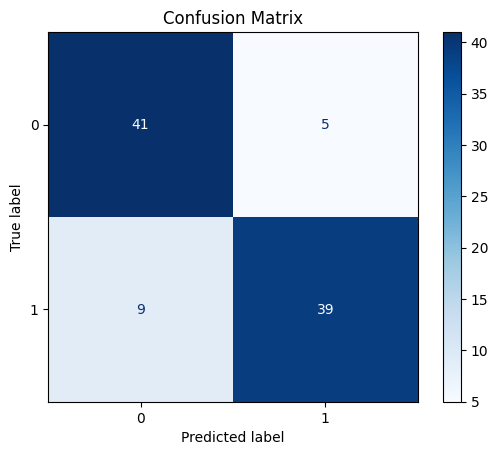

Validation Accuracy with best parameters: 0.85


In [26]:
# Наилучшие параметры, найденные Optuna
best_params = {
    'epochs': 40,
    'learning_rate': 0.0016098960132726436,
    'dense_units': 128,
    'dropout_rate': 0,
    'verbose': 0
}

# Создаем и обучаем модель с использованием лучших параметров
model = EfficientNetTrainer(**best_params)
model.fit(train_ds)

print("Score на обучающем подмножестве: ", model.score(train_ds))

# Оцениваем модель на валидационном наборе и выводим матрицу ошибок
val_accuracy = model.evaluate_and_plot_confusion_matrix(val_ds)
print(f"Validation Accuracy with best parameters: {val_accuracy:.2f}")

<h1> Сохраняем веса модели</h1>

In [27]:
model.model.save_weights("best_model_weights.h5")